# Control moment gyroscope

Import modules and configure the notebook.

In [1]:
# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import numpy as np
import matplotlib.pyplot as plt

# This is my own script (it is an interface to the pybullet simulator)
import ae353_cmg

# I often go back and forth between making changes to my scripts and to
# the notebook in which they are used. One "gotcha" is that notebooks only
# import modules or scripts ONCE. Subsequent imports don't do anything, and
# in particular won't reflect any changes I've made to my scripts. To make
# sure that I'm working with the latest version of my code, I use this bit
# of magic, which forces the notebook to "reload" my script:
import importlib
importlib.reload(ae353_cmg)

<module 'ae353_cmg' from 'C:\\Users\\Alec\\Documents\\Junior_Year\\AE_353\\ae353-sp22\\projects\\01_cmg\\ae353_cmg.py'>

Create an instance of the `Simulator` class, which is an interface to the [pybullet](http://pybullet.org) simulation engine.

There are several optional arguments:

* `display` (`True` or `False`) is whether or not to show the simulation window;
* `damping` (a non-negative floating-point number, default `0.`) is the coefficient of viscous friction at each joint;
* `load_mass` (a non-negative floating-point number, default `1.`) is the mass of the sphere attached to the platform;
* `roll` (an angle in radians, default `np.pi / 2`) is the roll angle of the ground.

**You must evaluate this cell only *once*.** If you want to start fresh with a new simulator, you must do `Kernel -> Restart` from the notebook menu first. If you evaluate this cell more than once without a call to `Kernel -> Restart` then you may get strange behavior that is hard to debug.

In [2]:
simulator = ae353_cmg.Simulator(
    display=True,
    damping=0.,
    load_mass=1.,
    roll=(np.pi / 2),
)

# EOM for CMG system

## $\ddot{q_1} = \frac{a_1\sin(2q_2)\dot{q_1}\dot{q_2} + a_2\cos(q_2)\dot{q_2}v_{rotor} + a_3\sin(q_1)}{a_4 + a_5\cos^2(q_2)}$

## $\ddot{q_2} = a_6\sin(2q_2)\dot{q_1}^2 + a_7\cos(q_2)\dot{q_1}v_{rotor} + a_8\tau$

### Where the following variables are functions of time...

* $q_1$ and $\dot{q_1}$ are the angle (rad) and angular velocity (rad/s) of the platform
* $q_2$ and $\dot{q_2}$ are the angle (rad) and angular velocity (rad/s) of the gimbal
* $\tau$ is the torque (Nm) applied by the platform to the gimbal

### And...

$v_{rotor} = 1000$ (technically a function of time, but assumed constant)

### With these EOM and the other parameters provided in the problem statement, a linear model can be created and expressed in state-space form. The following steps are followed...

* Choose a platform angle
* Linearize the model about an equilibrium point that corresponds to this platform angle and express the result in state-space form.
* Design a linear state feedback controller and verify that the closed-loop system is asymptotically stable in theory.
* Implement this controller and verify that the closed-loop system is asymptotically stable in simulation, at least when initial conditions are close to equilibrium.

# Choose a platform angle

## $q_1 = 0$

# Linearize model

## Define state

$$\begin{bmatrix} 
q_1 - q_{1e} \\ 
\dot{q_1} - \dot{q_{1e}} \\ 
q_2 - q_{2e} \\
\dot{q_2} - \dot{q_{2e}}
\end{bmatrix} =
\begin{bmatrix} 
q_1 - q_{1e} \\ 
v_1 - v_{1e} \\ 
q_2 - q_{2e} \\
v_2 - v_{2e}
\end{bmatrix}$$

## Define input

$$\begin{bmatrix} 
\tau - \tau_{e}
\end{bmatrix}$$


In [3]:
import numpy as np
import scipy
import sympy as sym

########################Intitalize variables########################

#Initialize constant variables as floats
J1z = 0.5
J2x = 0.001
J2z = 0.001
J3x = 0.01
J3y = 0.01
J3z = 0.01
m = 1.0
r = 2.0
g = 9.81
a1 = -J3y + 2*J3z
a2 = 2*J3y
a3 = -2*g*m*r
a4 = 2*J1z + 2*J2z + 2*m*r**2
a5 = 2*J3z
a6 = (J3y - J3z)/(2*(J2x + J3x))
a7 = -J3y/(J2x + J3x)
a8 = 1/(J2x + J3x)
vr = 1000.0

Define a controller that maps sensor measurements to actuator commands. By default, it chooses to apply zero torque to the gimbal. Modify the `run` function to make the controller behave differently.

In [4]:
def get_model(q1e):
    #create symbolic variables
    q1, q1dot, q1ddot, q2, q2dot, q2ddot, tau, v1, v2 = sym.symbols('q1, q1dot, q1ddot, q2, q2dot, q2ddot, tau, v1, v2')

    #choose angle

    ########################Find equilibrium point########################

    #Suppress scientific notation
    np.set_printoptions(suppress=True)

    #Create matrix, the method in which to find these equations is found in the report 
    f = sym.Matrix([v1, 
                    (a1*sym.sin(2*q2)*v1*v2 + a2*sym.cos(q2)*v2*vr + a3*sym.sin(q1))/(a4 + a5*(sym.cos(q2))**2), 
                    v2, 
                    a6*sym.sin(2*q2)*v1**2 + a7*sym.cos(q2)*v1*vr + a8*tau])

    #confirm equilibrium point
    f_num = sym.lambdify([v1, q1, v2, q2, tau], f)
    v1e = 0.
    v2e = 0.
    q2e = 0.
    taue = 0.
    if not f_num(v1e, q1e, v2e, q2e, taue).tolist() == [[0.0], [0.0], [0.0], [0.0]]:
        raise SystemExit("The chosen equilbrium point is invalid")

    ########################Find A and B matrices########################

    #Find A
    A_num = sym.lambdify((q1, v1, q2, v2, tau), f.jacobian([q1, v1, q2, v2,]))
    A = A_num(q1e, v1e, q2e, v2e, taue).astype(float)
    
    #Find B
    B_num = sym.lambdify((q1, v1, q2, v2, tau), f.jacobian([tau]))
    B = B_num(q1e, v1e, q2e, v2e, taue).astype(float)

    return A, B, v1e, v2e, q2e, taue

def find_K(A,B):
    # Find a good value of K
    #create random K arrays
    import random
    import numpy as np
    import scipy
    import sympy
    from scipy import linalg

    #Initialize K array to hold all different attempts of k (array of an array)
    K=[]

    #Initialize temporary variable k to hold a single guess of k (array of numbers)
    k=[]

    #Create x amount of k Matrices to test, and house them in K
    x = 10000
    for j in range(x):
        k=[]                                    #Reset temporary k
        for i in range(4):                      #Loop 4 times to create 4 entries in temporary k 
            k.append(random.uniform(0, 10))     #Actually create each random entry in k
        K.append(k)                             #Add temporary k to K, the array of all attmepts of K
    
    K = np.array(K, dtype=np.float64)           #Convert to float
    #p = np.array([[7., 3., 0.1, 3.]])
    #F = A-B@p
    #print(F)
    #s = linalg.eigvals(F)
    #Test k matrices that are housed in K
    for x in K:                                 #Loop through every k in K
        p = np.array([x])                        #Temporary variable p takes k and makes it a matrix to allows computation
        F = A-B@p                               #Evaluate F = A-Bx, where p = x
        s = linalg.eigvals(F)                   #Find eigen values
        if (s.real < 0).all() == True:          #Check if all real components of the eigen values of the current k are negative
            Candidate = p
            break                               #stop the program
    #print successful K!

    return Candidate / np.linalg.norm(Candidate)




In [5]:
q1e = 0 # <--------------------------------------- EQUILIBRIUM POINT CHOSEN
A, B, v1e, v2e, q2e, taue = get_model(q1e) # <---- FIND A, B, v1e, v2e, q2e, taue
Candidate = find_K(A,B) # <------------------------------- FIND K
K = Candidate.tolist()





In [6]:
K_attempt2 = [[0.95785119, 0.82270628, 0.24293576, 1.53188045]]
print(K_attempt2)

[[0.95785119, 0.82270628, 0.24293576, 1.53188045]]


In [7]:


class Controller:
    def __init__(self, K, v1e, q1e, v2e, q2e, taue):
        self.K = K
        self.q1e = q1e
        self.q2e = q2e
        self.v1e = v1e
        self.v2e = v2e
        self.taue = taue
    
    def reset(self):
        pass
    
    def run(
            self,
            t,
            platform_angle,
            platform_velocity,
            gimbal_angle,
            gimbal_velocity,
            rotor_velocity
        ):
        
        # Find state
        x = np.array([
            platform_angle - self.q1e,
            platform_velocity - self.v1e,
            gimbal_angle - self.q2e,
            gimbal_velocity - self.v2e,
        ])
        
        #Find input
        u = -self.K @ x
        
        #Find actuator command
        tau = u[0]
        
        gimbal_torque = tau
        return gimbal_torque

#Choose gain matrix
K = np.array(K_attempt2)

# Create instance of controller with this gain matrix
controller = Controller(K, q1e, q2e, v1e, v2e, taue)
    
    

Create an instance of the controller.

Reset the simulator with given initial conditions. A low-level controller (separate from yours) will try to ensure that the rotor velocity remains constant.

In [8]:
simulator.reset(
    platform_angle=np.pi/6,
    platform_velocity=1.,
    gimbal_angle=0.,
    gimbal_velocity=0.,
    rotor_velocity=1000.,
)

Reset the controller.

In [9]:
controller.reset()

Choose a camera view (could be `simulator.camera_topview()` or `simulator.camera_sideview()`).

In [10]:
simulator.camera_sideview()

Run the simulator.

In [11]:
data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=10.0,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
)

Get, show, and save a snapshot of the simulation after the last time step.

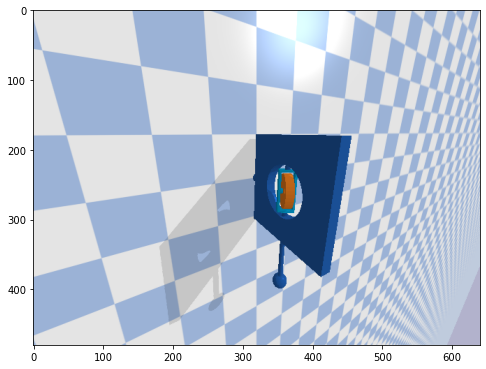

In [12]:
# Get snapshot as height x width x 4 numpy array of RGBA values
rgba = simulator.snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

Plot the results.

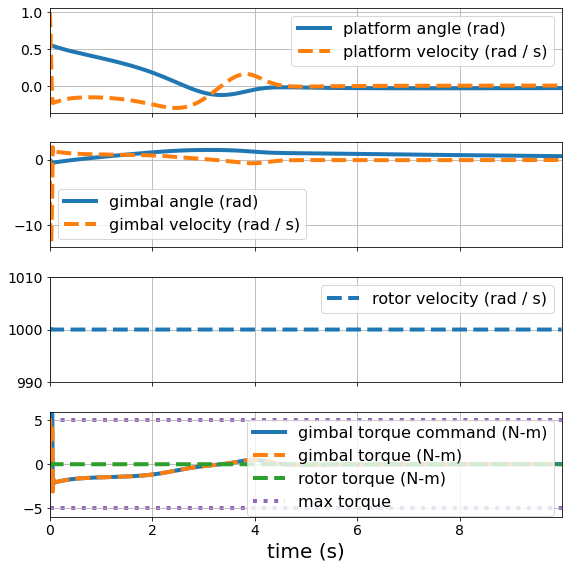

In [13]:
# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_platform, ax_gimbal, ax_rotor, ax_torque) = plt.subplots(4, 1, figsize=(8, 8), sharex=True)

# Plot platform angle and velocity
ax_platform.plot(
    data['t'], data['platform_angle'],
    label='platform angle (rad)', linewidth=4,
)
ax_platform.plot(
    data['t'], data['platform_velocity'],
    '--', label='platform velocity (rad / s)', linewidth=4,
)
ax_platform.grid()
ax_platform.legend(fontsize=16)
ax_platform.tick_params(labelsize=14)

# Plot gimbal angle and velocity
ax_gimbal.plot(
    data['t'], data['gimbal_angle'],
    label='gimbal angle (rad)', linewidth=4,
)
ax_gimbal.plot(
    data['t'], data['gimbal_velocity'],
    '--', label='gimbal velocity (rad / s)', linewidth=4,
)
ax_gimbal.grid()
ax_gimbal.legend(fontsize=16)
ax_gimbal.tick_params(labelsize=14)

# Plot rotor velocity
ax_rotor.plot(
    data['t'], data['rotor_velocity'],
    '--', label='rotor velocity (rad / s)', linewidth=4,
)
ax_rotor.grid()
ax_rotor.legend(fontsize=16)
ax_rotor.tick_params(labelsize=14)
ax_rotor.set_ylim(simulator.rotor_velocity - 10., simulator.rotor_velocity + 10.)

# Plot torques
ax_torque.plot(
    data['t'], data['gimbal_torque_command'],
    label='gimbal torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['gimbal_torque'],
    '--', label='gimbal torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['rotor_torque'],
    '--', label='rotor torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', label='max torque', linewidth=4, color='C4', zorder=0,
)
ax_torque.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.grid()
ax_torque.legend(fontsize=16)
ax_torque.tick_params(labelsize=14)

# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_torque.set_xlabel('time (s)', fontsize=20)
ax_torque.set_xlim([data['t'][0], data['t'][-1]])
ax_torque.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Make the arrangement of subplots look nice
fig.tight_layout()

Save the figure (without transparent background).

In [14]:
fig.savefig('my_figure.png', facecolor='white', transparent=False)